# Skeleton data

Use [Openpose](https://github.com/CMU-Perceptual-Computing-Lab/openpose) human pose estimation algorithm to infer the skeleton from RGB data.

Keras code adapted from [here](https://github.com/ildoonet/tf-pose-estimation).


## 1. Extract skeleton

In [0]:
#@markdown Run this cell to install Openpose + dependencies.

%%capture

import tensorflow as tf
import os

!pip install opencv-contrib-python
!apt-get install protobuf-compiler
!apt-get install python3-tk

!git clone https://www.github.com/ildoonet/tf-openpose

os.chdir('tf-openpose')
!pip3 install -r requirements.txt

os.chdir('tf_pose/pafprocess')
!apt-get install swig
!swig -python -c++ pafprocess.i && python3 setup.py build_ext --inplace

os.chdir('/content/tf-openpose/')
!wget "https://i.imgur.com/HRdIEIS.png"

In [47]:
#@title Upload image

from google.colab import files

uploaded_files = files.upload()

for fname in uploaded_files.keys():
    my_image = '/content/tf-openpose/' + fname
    break
print("Saved image path to |my_image|.")

Saving Screenshot from 2019-06-24 03-25-19.png to Screenshot from 2019-06-24 03-25-19.png
Saved image path to |my_image|.


Do not decrease the size of the image too much, because the algorithm works better on high quality images.

[2019-06-24 00:26:24,714] [TfPoseEstimator] [INFO] loading graph from /content/tf-openpose/models/graph/mobilenet_thin/graph_opt.pb(default size=400x400)
I0624 00:26:24.714553 139793761978240 estimator.py:309] loading graph from /content/tf-openpose/models/graph/mobilenet_thin/graph_opt.pb(default size=400x400)


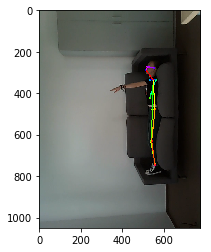

In [48]:
from tf_pose import common
import cv2
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh
import matplotlib.pyplot as plt

w, h = model_wh('400x400')
e = TfPoseEstimator(get_graph_path('mobilenet_thin'), target_size=(w, h))

image = common.read_imgfile(my_image, None, None)
# print(image.shape)
humans = e.inference(image,
                     resize_to_default=(w > 0 and h > 0),
                     upsample_size=4.0)
image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)

plt.grid(False)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

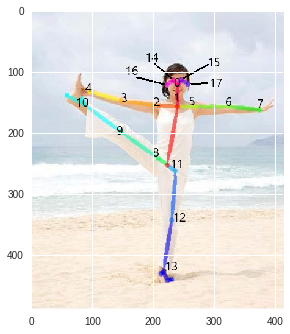

In [0]:
#@title A closer look to skeleton data

#@markdown Run this cell to view the correspondence between body parts and numerical values.

image = cv2.imread("HRdIEIS.png")

fig = plt.figure()
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [0]:
for human in humans:
    for bp in human.body_parts.values():
        print("%d (%s): location (%.2f, %.2f), confidence score %.2f" 
              % (bp.part_idx, bp.get_part_name(), bp.x, bp.y, bp.score))

0 (CocoPart.Nose): location (0.54, 0.20), confidence score 0.74
1 (CocoPart.Neck): location (0.54, 0.34), confidence score 0.76
2 (CocoPart.RShoulder): location (0.46, 0.34), confidence score 0.74
3 (CocoPart.RElbow): location (0.44, 0.51), confidence score 0.55
4 (CocoPart.RWrist): location (0.44, 0.68), confidence score 0.67
5 (CocoPart.LShoulder): location (0.61, 0.35), confidence score 0.60
6 (CocoPart.LElbow): location (0.63, 0.51), confidence score 0.40
7 (CocoPart.LWrist): location (0.65, 0.68), confidence score 0.58
8 (CocoPart.RHip): location (0.49, 0.65), confidence score 0.43
9 (CocoPart.RKnee): location (0.51, 0.84), confidence score 0.55
10 (CocoPart.RAnkle): location (0.51, 0.94), confidence score 0.28
11 (CocoPart.LHip): location (0.58, 0.66), confidence score 0.45
12 (CocoPart.LKnee): location (0.57, 0.85), confidence score 0.44
13 (CocoPart.LAnkle): location (0.57, 0.94), confidence score 0.15
14 (CocoPart.REye): location (0.52, 0.18), confidence score 0.82
15 (CocoPar

## 2. Compute skeleton image from video

In [3]:
#@markdown Run this cell to mount Google Drive.

!apt-get install -y -qq software-properties-common module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

W: Failed to fetch https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/InRelease  502  Bad Gateway [IP: 192.229.232.112 443]
W: Some index files failed to download. They have been ignored, or old ones used instead.
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131733 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.4-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.4-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.4-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the 

In [0]:
import os
os.chdir("/content")

!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
root = "/content/drive/own/"
os.chdir("/content/tf-openpose")

In [6]:
#@markdown Run this cell to import helper class `Videos`.

import matplotlib.pyplot as plt
%matplotlib inline

def plotImages(images_arr):
    fig, axes = plt.subplots(4, 6, figsize=(10, 6))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        if img.ndim != 2:
            img = img.reshape((SIZE, SIZE))
        ax.imshow( img, cmap="Greys_r")
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout()

!pip3 install sk-video

import numpy as np
from skvideo.io import FFmpegReader, ffprobe
from skvideo.utils import rgb2gray
from PIL import Image
from keras.preprocessing import image
from tqdm import tqdm


class Videos(object):

    def __init__(self, target_size=None, to_gray=True, max_frames=None,
                 extract_frames='middle', required_fps=None,
                 normalize_pixels=None):
        """
        Initializing the config variables
        Parameters:
            target_size (tuple): (New_Width, New_Height), Default 'None'
                A tuple denoting the target width and height of each frame in each of the video
            to_gray (boolean): Default 'True'
                If True, then each frame will be converted to gray scale. Otherwise, not.
            max_frames (int): Default 'None'
                The maximum number of frames to return for each video.
                Extra frames are removed based on the value of 'extract_frames'.
            extract_frames (str): {'first', 'middle', 'last'}, Default 'middle'
                'first': Extract the first 'N' frames
                'last': Extract the last 'N' frames
                'middle': Extract 'N' frames from the middle
                    Remove ((total_frames - max_frames) // 2) frames from the beginning as well as the end
            required_fps (int): Default 'None'
                Capture 'N' frame(s) per second from the video.
                Only the first 'N' frame(s) for each second in the video are captured.
            normalize_pixels (tuple/str): Default 'None'
                If 'None', the pixels will not be normalized.
                If a tuple - (New_min, New_max) is passed, Min-max Normalization will be used.
                If the value is 'z-score', then Z-score Normalization will be used.
                For each pixel p, z_score = (p - mean) / std
        """

        self.target_size = target_size
        self.to_gray = to_gray
        self.max_frames = max_frames
        self.extract_frames = extract_frames
        self.required_fps = required_fps
        self.normalize_pixels = normalize_pixels
        self.fps = None

    def read_videos(self, paths):
        """
        Parameters:
            paths (list): Required
                 A list of paths of the videos to be read
        Returns:
            Numpy.ndarray
                A 5-d tensor with shape (<No. of Videos>, <No. of frames>, <height>, <width>, <channels>)
        """

        list_of_videos = [
            self._read_video(path) for path in tqdm(paths)
        ]
		
        tensor = np.vstack(list_of_videos)

        if self.normalize_pixels != None:
            # Pixels are normalized for each video individually
            if (type(self.normalize_pixels) == tuple) and (len(self.normalize_pixels) == 2):
                base = self.normalize_pixels[0]
                r = self.normalize_pixels[1] - base
                min_ = np.min(tensor, axis=(1, 2, 3), keepdims=True)
                max_ = np.max(tensor, axis=(1, 2, 3), keepdims=True)
                return ((tensor.astype('float32') - min_) / (max_ - min_)) * r + base

            elif self.normalize_pixels == 'z-score':
                mean = np.mean(tensor, axis=(1, 2, 3), keepdims=True)
                std = np.std(tensor, axis=(1, 2, 3), keepdims=True)
                return (tensor.astype('float32') - mean) / std
            
            else:
                raise ValueError('Invalid value of \'normalize_pixels\'')

        return tensor

    def get_frame_count(self, paths):
        """
        Can be used to determine the value of `max_frames`
        Parameters:
            paths (list): Required
                 A list of paths of the videos to be read
        Returns:
            dict (python dictionary)
                For each video, the total number of frames in that video is stored in the dictionary.
        """

        frame_count = {}
        for path in paths:
            cap = FFmpegReader(filename=path)
            frame_count[path] = cap.inputframenum
            cap.close()

        return frame_count

    def _read_video(self, path):
        """
        Parameters:
            path (str): Required
                Path of the video to be read
        Returns:
            Numpy.ndarray
                A 5-d tensor with shape (1, <No. of frames>, <height>, <width>, <channels>)
        """

        cap = FFmpegReader(filename=path)
        list_of_frames = []
        self.fps = int(cap.inputfps)                  # Frame Rate

        for index, frame in enumerate(cap.nextFrame()):

            capture_frame = True
            if self.required_fps != None:
                is_valid = range(self.required_fps)
                capture_frame = (index % self.fps) in is_valid

            if capture_frame:

                if self.target_size is not None:
                    temp_image = image.array_to_img(frame)
                    frame = image.img_to_array(
                        temp_image.resize(
                            self.target_size,
                            Image.ANTIALIAS)).astype('uint8')

                # Shape of each frame -> (<height>, <width>, 3)
                list_of_frames.append(frame)

        temp_video = np.stack(list_of_frames)
        cap.close()

        if self.to_gray:
            temp_video = rgb2gray(temp_video)
                
        if self.max_frames is not None:
            temp_video = self._process_video(video=temp_video)

        return np.expand_dims(temp_video, axis=0)

    def _process_video(self, video):
        """
        Parameters:
            video (Numpy.ndarray):
                Shape = (<No. of frames>, <height>, <width>, <channels>)
                Video whose frames are to be extracted
        Returns:
            Numpy.ndarray
                A tensor (processed video) with shape (<`max_frames`>, <height>, <width>, <channels>)
        """

        total_frames = video.shape[0]
        if self.max_frames <= total_frames:

            if self.extract_frames == 'first':
                video = video[:self.max_frames]
            elif self.extract_frames == 'last':
                video = video[(total_frames - self.max_frames):]
            elif self.extract_frames == 'middle':
                # No. of frames to remove from the front
                front = ((total_frames - self.max_frames) // 2) + 1
                video = video[front:(front + self.max_frames)]
            else:
                raise ValueError('Invalid value of \'extract_frames\'')

        else:
            raise IndexError(
                'Required number of frames is greater than the total number of frames in the video')

        return video

     |████████████████████████████████| 2.3MB 45.0MB/s 


Using TensorFlow backend.


In [0]:
#SIZE = 400
NFRAMES = 24

def get_reader():
    return Videos(#target_size=(SIZE, SIZE), 
                  to_gray=False, 
                  #max_frames=NFRAMES, 
                  extract_frames='middle',
                  required_fps=30,
                  normalize_pixels=None)

In [0]:
# In HSV format. To decrease intensity, decrease V.
colors = {'background': [0, 0, 100],  # white
          'larm': [0, 100, 100],    # red
          'rarm': [120, 100, 100],  # green
          'lleg': [60, 100, 100],   # yellow
          'rleg': [300, 100, 100],  # pink
          'trunk': [240, 100, 100]} # blue

bp_groups = {0: 'trunk', 1: 'trunk', 2: 'trunk', 3: 'rarm', 4: 'rarm',
             5: 'trunk', 6: 'larm', 7: 'larm', 8: 'trunk', 9: 'rleg',
             10: 'rleg', 11: 'trunk', 12: 'lleg', 13: 'lleg'}
ordered_ids = [0, #1, 2, 5, 8, 11,
               3, 4,
               6, 7,
               #9, 10,
               #12, 13
              ]

def get_delta(frame_id, no_frames):
    return frame_id * 0.5 / (no_frames - 1)

def colorize(i, j, color, skimage):
    for ii in range(-2, 3):
        for jj in range(-2, 3):
            if ii + i >= 0 and ii + i < 100 and jj + j >= 0 and jj + j < 100:
                if skimage[ii + i][jj + j] == colors['background']:
                    skimage[ii + i][jj + j][0] = color[0]
                    skimage[ii + i][jj + j][1] = color[1]

                # Change Value according to frame number.
                skimage[ii + i][jj + j][2] = color[2] * (1 - delta)

                
def update_skimage(skimage, body_parts, delta):
    for bp in body_parts:
        #if bp.score > 0.5:
        for id in ordered_ids:
            if bp.part_idx == id: 
                i = int(bp.y * 100)
                j = int(bp.x * 100)
                color = colors[bp_groups[bp.part_idx]] 
                colorize(i, j, color, skimage)


In [0]:
import cv2
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh
import matplotlib.pyplot as plt
from copy import deepcopy

In [0]:
fnames = [root + '1_13.mp4']

In [38]:
reader = get_reader()
videos = reader.read_videos(fnames)

100%|██████████| 1/1 [00:07<00:00,  7.79s/it]


In [43]:
(_, _, h, w, _) = videos.shape
e = TfPoseEstimator(get_graph_path('mobilenet_thin'), target_size=(w, h))

[2019-06-24 00:22:48,004] [TfPoseEstimator] [INFO] loading graph from /content/tf-openpose/models/graph/mobilenet_v2_large/graph_opt.pb(default size=1280x960)
I0624 00:22:48.004704 139793761978240 estimator.py:309] loading graph from /content/tf-openpose/models/graph/mobilenet_v2_large/graph_opt.pb(default size=1280x960)


In [0]:
for video in videos:
    skimage = [[deepcopy(colors['background']) for _ in range(100)] for _ in range(100)]
    no_frames = len(video)
    
    for frame_id in range(no_frames):
        frame = video[frame_id]
        humans = e.inference(frame,
                             resize_to_default=(w > 0 and h > 0),
                             upsample_size=4.0)
        delta = get_delta(frame_id, no_frames)
        
        '''min_ox = 9999
        min_idx = None
        for idx in range(len(humans)):
            human = humans[idx]
            for bp in human.body_parts.values():
                if bp.part_idx == 0 and bp.y < min_ox:
                    min_ox = bp.y
                    min_idx = idx
        if min_idx != None:
            update_skimage(skimage, humans[min_idx].body_parts.values(), delta)'''
             
        for human in humans:
            update_skimage(skimage, human.body_parts.values(), delta)

In [0]:
import colorsys

rgb_skimage = [[colorsys.hsv_to_rgb(round(e[0]) / 360, round(e[1]) / 100, round(e[2]) / 100) for e in row] for row in skimage]

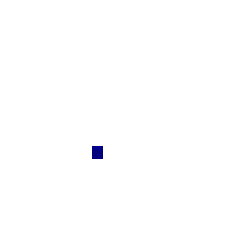

In [46]:
from matplotlib import pyplot as plt

plt.axis('off')
plt.grid(False)
plt.imshow(rgb_skimage)